In [2]:
import hoomd
from hoomd import md
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import itertools
import math
import numpy
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline


matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
#Imports needed

In [4]:
#Polymer Setup


#Degree of Polymerization
DOP = 20

num_chains = 400
equil_volume = 8000
L = equil_volume ** (1/3)
x = numpy.linspace(-L / 2, L / 2, DOP, endpoint = False)

frame = gsd.hoomd.Frame()

# Set position data for GSD
num_particles = DOP * num_chains
position = list(itertools.product(x, repeat=3))

frame.particles.N = num_particles
frame.particles.position = position[0:num_particles]
frame.particles.typeid = [0,1] * (num_particles//2)
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.types = ['A', 'B']

# Set bond data for GSD
num_bonds = (DOP - 1) * num_chains
frame.bonds.N = num_bonds
frame.bonds.types = ['polybond']
frame.bonds.typeid = [0] * (num_bonds)
bond_list = []


bond_list = [[i, i + 1] for i in range(num_particles - 1) if i % DOP != DOP - 1]

frame.bonds.group = bond_list

# Set angle data for GSD
num_angles = (DOP - 2) * num_chains
frame.angles.N = num_angles
frame.angles.types = ['polyangle']
frame.angles.typeid = [0] * (num_angles)
angle_list = []


for n in range(1, num_particles + 1, 1):
    if (n % DOP != 0) and ((n + 1) % DOP != 0):
        angle_list.append([n - 1, n, n + 1])

frame.angles.group = angle_list


with gsd.hoomd.open(name='polymer.gsd', mode='x') as f:
    f.append(frame)

In [5]:
# Access widget values in the simulation loop
field_strength = 10
field_axis = "x"
#Change if needed

In [6]:
#Add LJ interactions between the polymers
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A','A')] = dict(epsilon=1, sigma=1)
lj.params[('A','B')] = dict(epsilon=1.2, sigma=0.8)
lj.params[('B', 'B')] = dict(epsilon=1.4, sigma=0.6)
lj.r_cut[('A', 'A'), ('A','B'), ('B','B')] = 2.5


# Add an external field along the selected axis
electric = hoomd.md.external.field.Electric()

#Apply user input
if field_axis == 'x':
    electric.E['A','B'] = (field_strength, 0, 0)
elif field_axis == 'y':
    electric.E['A','B'] = (0, field_strength, 0)
else:
    electric.E['A','B'] = (0, 0, field_strength)


langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=0.005, methods=[langevin], forces=[electric, lj])
gsd_writer = hoomd.write.GSD(filename='impact.gsd', trigger=hoomd.trigger.Periodic(10), mode='xb')
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
sim.create_state_from_gsd(filename='polymer.gsd')

sim.operations.integrator = integrator
sim.operations.writers.append(gsd_writer)

In [7]:
n_steps = 1000
for n in range(n_steps):
    sim.run(1)
    

In [8]:
gsd_writer.flush()

/var/folders/53/ht72v4cx1873kmnhk4qlqtk40000gn/T/ipykernel_83462/3156232811.py:7: RuntimeWarning: divide by zero encountered in divide
  V_lj = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
/var/folders/53/ht72v4cx1873kmnhk4qlqtk40000gn/T/ipykernel_83462/3156232811.py:7: RuntimeWarning: invalid value encountered in subtract
  V_lj = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)


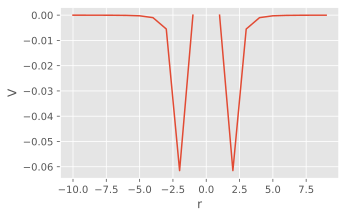

In [18]:
#Analysis of system energies for LJ force


sigma = 1
epsilon = 1
r = x
V_lj = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(r, V_lj)
ax.set_xlabel('r')
ax.set_ylabel('V')
fig

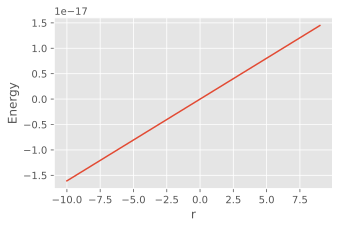

In [16]:
#Analyzing field energies

q = 1.609 * 10**(-19)
r = x
E = r * q * field_strength

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(r, E)
ax.set_xlabel('r')
ax.set_ylabel('Energy')
fig

#Displays that during the inital state, enegies were highest in magnitude for particles 
#farthest from the axis that the field is applied.

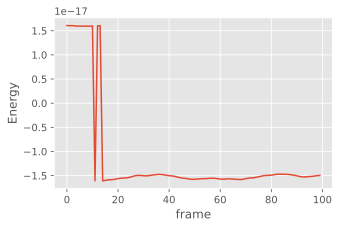

In [17]:
traj = gsd.hoomd.open('impact.gsd')

q = 1.609 * 10 ** (-19)
y = [ ]
for frame in traj:
    energy = frame.particles.position[0][0] * q * field_strength
    y.append(energy)

Frames = range(len(traj))
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(Frames, y)
ax.set_xlabel('frame')
ax.set_ylabel('Energy')
fig